In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 凸优化库
from cvxopt.solvers import qp
from cvxopt import matrix

定义生成数据集的类

In [19]:
class Dataset:
    def __init__(self, means1=[-5, 0], means2=[0, 5]):
        self._random_sample(means1, means2)

    def _random_sample(self, means1, means2):
        means1, means2 = np.array(means1), np.array(means2)
        covar = np.array([1,0,0,1]).reshape(2,2)
        x1, y1 = np.random.multivariate_normal(means1, covar, size=200), np.ones((200, 1))
        x2, y2 = np.random.multivariate_normal(means2, covar, size=200), np.ones((200, 1)) * -1
        self._split(x1, y1, x2, y2)

    def _split(self, x1, y1, x2, y2):
        train_n1, train_n2 = int(x1.shape[0] * 0.8), int(x2.shape[0] * 0.8)
        self.x_train = np.concatenate((x1[:train_n1], x2[:train_n2]), axis=0)
        self.y_train = np.concatenate((y1[:train_n1], y2[:train_n2]), axis=0)
        self.x_test = np.concatenate((x1[train_n1:], x2[train_n2:]), axis=0)
        self.y_test = np.concatenate((y1[train_n1:], y2[train_n2:]), axis=0)

#### 二、SVM模型实现

##### 1. 线性支持向量机

In [20]:
# 定义Hinge Loss
def hinge_loss(y, yhat):
    batch_size = y.shape[0]
    loss = 1-y*yhat
    loss = np.clip(loss, a_min=0, a_max=None)
    return np.sum(loss,axis=0)/batch_size

# 线性支持向量机
class SVM:
    def __init__(self, dimension=2):
        self.dimension = dimension
        self.w = np.zeros((dimension+1,1))

    def quadratic_programming(self, x, y):
        # 使用二次规划求解
        n, dimension = x.shape
        if dimension != self.dimension:
            raise

        Q = np.eye(self.dimension+1)
        Q[0][0] = 0
        p = np.zeros((self.dimension+1,1))
        A = -y * np.concatenate((np.ones((n,1)) , x), axis=1)
        c = -1 * np.ones((n,1))
        Q,p,A,c = matrix(Q),matrix(p),matrix(A),matrix(c)

        slv = qp(Q, p, A, c)['x']
        self.w = np.array(slv).reshape(dimension+1,1)

    def train(self, x, y, epoch=10, lr=0.1):
        # 梯度下降求解
        n, dimension = x.shape
        exdim = np.ones((n,1))
        x = np.concatenate((exdim, x), axis=1) ## 增广化
        
        losses = []
        for n_epoch in range(epoch):
            yhat = np.matmul(x,self.w)
            loss = hinge_loss(y, yhat)
            losses.append(loss)
            grad = self._caculate_grad(x, y, yhat)
            self.w -= lr * grad
            print('epoch: %i/%i  loss: %.2f'%(n_epoch+1, epoch, loss))
        return losses


    def _caculate_grad(self, x, y, yhat):
        index = np.where((1 - y * yhat) < 0)[0]
        grad = -y * x
        grad[index] = 0
        grad = np.sum(grad, axis=0)
        return grad.reshape(self.dimension+1, 1)

    def eval(self, x, y):
        n, dimension = x.shape
        if not dimension == self.dimension:
            raise
        exdim = np.ones((n,1))
        x = np.concatenate((exdim, x), axis=1)
        yhat = np.matmul(x, self.w)
        yhat = np.sign(yhat)
        correct = len(np.where(yhat == y)[0])
        print('测试集准确率 %.2f'%(correct/n))

# 对偶支持向量机
class DualSVM(SVM):
    def __init__(self, dimension=2):
        self.dimension = dimension
        self.w = np.zeros((dimension,1))  ## 不做增广化
        self.b = 0

    def quadratic_programming(self, z, y, epsilon=1e-8):
        '''
            solve convex optim problem
            min { 1/2 * u.T * Q * u + p.T * u }
            s.t: A * u <= C & R * u = v
        '''
        n, dimension = z.shape
        if not dimension == self.dimension:
            raise

        Q = np.matmul(y,y.T) * np.matmul(z, z.T)
        p = -1 * np.ones((n,1))
        A = -1 * np.eye(n)
        c = np.zeros((n,1))
        R = y.T
        v = np.zeros((1,1))
        Q,p,A,c,R,v = matrix(Q),matrix(p),matrix(A),matrix(c),matrix(R),matrix(v)

        alpha = np.array(qp(Q, p, A, c, R, v)['x'])
        idx = np.where(alpha>epsilon)[0]

        self.w = np.sum(alpha * y * z, axis=0).reshape(dimension, 1)
        self.b = y[idx[0]] - np.matmul(z[idx[0]], self.w)
        self.support_vector = z[idx]
        self.support_vector_y = y[idx]

    def eval(self, x, y):
        n, dimension = x.shape
        if not dimension == self.dimension:
            raise

        yhat = np.matmul(x, self.w) + self.b
        yhat = np.sign(yhat)
        correct = len(np.where(yhat == y)[0])
        print('测试集准确率 %.2f'%(correct/n))


# 核支持向量机
class KernelSVM(SVM):
    def __init__(self, nonlinear=2, zeta=1, gamma=1, gauss=False):
        '''
            dimension: 线性核转换维度
            nonlinear: 非线性核
            gauss: 使用高斯核
        '''
        self.nonlinear = nonlinear
        self.zeta = zeta
        self.gamma = gamma
        self.gauss = gauss

    def quadratic_programming(self, x, y):
        n, dimension = x.shape
        # 高斯核
        if self.gauss:
            kernel = self._caculate_gauss_kernel(x, x)
        # 多项式核
        else:
            kernel = self._caculate_kernel(x, x)

        Q = np.matmul(y,y.T) * kernel
        p = -1 * np.ones((n,1))
        A = -1 * np.eye(n)
        c = np.zeros((n,1))
        R = y.T
        v = np.zeros((1,1))
        Q,p,A,c,R,v = matrix(Q),matrix(p),matrix(A),matrix(c),matrix(R),matrix(v)


        alpha = np.array(qp(Q, p, A, c, R, v)['x'])
        idx = np.where(alpha>1e-8)[0][0]

        idx = np.where(alpha>1e-6)[0]
        self.alpha = alpha[idx]
        self.sv = x[idx]
        self.sv_y = y[idx]
        x_query, y_query = self.sv[0].reshape(1,-1), self.sv_y[0]

        if self.gauss:
            kernel_value = self._caculate_gauss_kernel(x_query, self.sv)
        else:
            kernel_value = self._caculate_kernel(x_query, self.sv)
        self.b = y_query - np.sum(self.alpha * self.sv_y * kernel_value)

    def __call__(self, x):
        n, dimension = x.shape
        if self.gauss:
            kernel_value = self._caculate_gauss_kernel(x, self.sv)
        else:
            kernel_value = self._caculate_kernel(x, self.sv)
        yhat = np.sum(self.alpha * self.sv_y * kernel_value, axis=0) + self.b
        yhat = np.sign(yhat).reshape(n,1)
        return yhat

    def eval(self, x, y):
        n, dimension = x.shape
        if self.gauss:
            kernel_value = self._caculate_gauss_kernel(x, self.sv)
        else:
            kernel_value = self._caculate_kernel(x, self.sv)
        yhat = np.sum(self.alpha * self.sv_y * kernel_value, axis=0) + self.b
        yhat = np.sign(yhat).reshape(n,1)
        correct = len(np.where(yhat == y)[0])
        print('测试集准确率 %.2f'%(correct/n))

    def _caculate_kernel(self, x, sv_x):
        n, dimension1 = sv_x.shape
        m, dimension2 = x.shape
        assert(dimension1 == dimension2)
        kernel_value = np.power(self.zeta + self.gamma * np.matmul(sv_x, x.T), self.nonlinear)
        return kernel_value.reshape(n,m)

    def _caculate_gauss_kernel(self, x, sv_x):
        n, dimension1 = sv_x.shape
        m, dimension2 = x.shape
        assert(dimension1 == dimension2)
        graph1 = np.repeat(np.expand_dims(x, axis=0), n, axis=0)
        graph2 = np.repeat(np.expand_dims(sv_x, axis=0), m, axis=0).transpose(1,0,2)
        kernel_value = np.exp(-self.gamma * np.linalg.norm(graph1 - graph2, axis=-1))
        return kernel_value

生成随机点数据并可视化

Size of Dataset: 
x_train: (320, 2)
y_train: (320, 1)
x_test: (80, 2)
y_test: (80, 1)


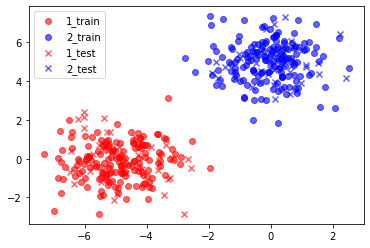

In [21]:
data1 = Dataset()
x_train, x_test = data1.x_train, data1.x_test
y_train, y_test = data1.y_train, data1.y_test
print('Size of Dataset: ')
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test: {}".format(y_test.shape))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.6, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.6, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.6, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.6, marker='x', c='blue')
plt.legend(handles=[c1, c2, c3, c4],labels=['1_train','2_train', '1_test', '2_test'],loc='best')
plt.show()

**线性支持向量机**

使用二次规划求解的线性支持向量机计算最大间隔面，并用测试机测试准确率。

     pcost       dcost       gap    pres   dres
 0:  3.4160e-02  6.6722e+01  1e+03  2e+00  2e+03
 1:  1.8356e-01 -2.8020e+02  6e+02  9e-01  1e+03
 2:  5.6512e-01 -2.9180e+02  4e+02  5e-01  5e+02
 3:  7.1037e-01 -2.8145e+02  4e+02  4e-01  4e+02
 4:  1.0465e+00 -1.1104e+02  1e+02  1e-01  1e+02
 5:  1.1840e+00 -9.4898e+00  1e+01  1e-02  1e+01
 6:  1.0128e+00  1.9671e-01  8e-01  4e-04  4e-01
 7:  8.9733e-01  8.2759e-01  7e-02  8e-07  8e-04
 8:  8.9444e-01  8.9371e-01  7e-04  9e-09  9e-06
 9:  8.9440e-01  8.9440e-01  7e-06  9e-11  9e-08
10:  8.9440e-01  8.9440e-01  7e-08  9e-13  9e-10
Optimal solution found.
w: [[-1.06720173]
 [-0.80615405]]
b: [0.00934815]
测试集准确率 1.00


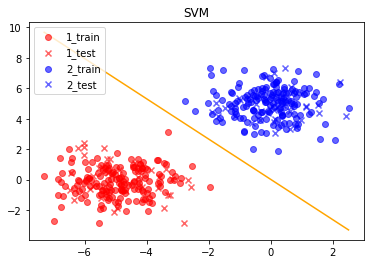

In [22]:
model1 = SVM(dimension=2)
model1.quadratic_programming(x_train, y_train)

b, w = model1.w[0], model1.w[1:]
print('w: {}'.format(w))
print('b: {}'.format(b))
model1.eval(x_test, y_test)

plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.6, marker='o', c='red')
plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.6, marker='o', c='blue')
plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.6, marker='x', c='red')
plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.6, marker='x', c='blue')
plt.legend(handles=[c1, c3, c2, c4],labels=['1_train', '1_test', '2_train', '2_test'],loc='best')

xmax, xmin = np.max(x_train[:,0]), np.min(x_train[:,0])
point1, point2 = [xmin, xmax], [-(w[0]*xmin+b)/w[1], -(w[0]*xmax+b)/w[1]]
plt.plot(point1, point2, c='orange')
plt.title('SVM')
plt.show()

**对偶支持向量机**

将计算复杂度与特征维数相关转化为了与训练样本个数相关。

     pcost       dcost       gap    pres   dres
 0: -2.3996e+01 -4.7743e+01  1e+03  3e+01  2e+00
 1: -2.8289e+01 -2.7023e+01  6e+02  2e+01  9e-01
 2: -6.2384e+01 -3.2204e+01  4e+02  8e+00  5e-01
 3: -5.6138e+01 -2.3568e+01  4e+02  6e+00  4e-01
 4: -3.5564e+01 -5.8383e+00  1e+02  2e+00  1e-01
 5: -3.1971e+00 -1.2293e+00  1e+01  2e-01  1e-02
 6: -6.0211e-01 -1.0134e+00  8e-01  6e-03  4e-04
 7: -8.2846e-01 -8.9733e-01  7e-02  1e-05  8e-07
 8: -8.9372e-01 -8.9444e-01  7e-04  1e-07  9e-09
 9: -8.9440e-01 -8.9440e-01  7e-06  1e-09  9e-11
10: -8.9440e-01 -8.9440e-01  7e-08  1e-11  9e-13
Optimal solution found.
w: [[-1.06720173]
 [-0.80615405]]
b: [0.00934815]
测试集准确率 1.00


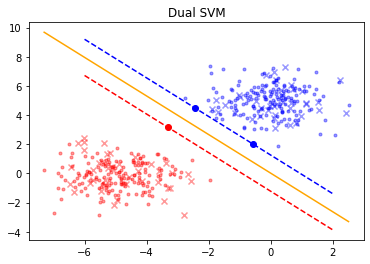

In [23]:
model2 = DualSVM(dimension=2)
model2.quadratic_programming(x_train, y_train)

sv, sv_y = model2.support_vector, model2.support_vector_y
b, w = model1.w[0], model1.w[1:]
print('w: {}'.format(w))
print('b: {}'.format(b))
model2.eval(x_test, y_test)

plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='.', c='red')
plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='.', c='blue')
plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='red')
plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')

pos_idx = np.where(sv_y==1)[0]
pos_sv = sv[pos_idx]
neg_idx = np.where(sv_y==-1)[0]
neg_sv = sv[neg_idx]
plt.scatter(pos_sv[:,0], pos_sv[:,1], alpha=1, marker='o', c='red')
plt.scatter(neg_sv[:,0], neg_sv[:,1], alpha=1, marker='o', c='blue')


xmax, xmin = np.max(x_train[:,0]), np.min(x_train[:,0])
point1, point2 = [xmin, xmax], [-(w[0]*xmin+b)/w[1], -(w[0]*xmax+b)/w[1]]
plt.plot(point1,point2,c='orange')

x = np.linspace(-6, 2, 100)
pos_b = - w[0] * pos_sv[0][0] - w[1] * pos_sv[0][1]
pos_f = -(w[0] * x+pos_b) / w[1]
neg_b = - w[0] * neg_sv[0][0] - w[1] * neg_sv[0][1]
neg_f = -(w[0] * x+neg_b) / w[1]

plt.plot(x, pos_f, '--', c='red')
plt.plot(x, neg_f, '--', c='blue')
plt.title('Dual SVM')
plt.show()

**核函数支持向量机**

核函数支持向量机利用核函数将数据映射到高维空间，故分类面不再是线性。

首先定义画非线性分类面函数

In [24]:
def plot_decision_boundary(x, pred_func, h=0.1):  

    # 设定最大最小值，边缘填充  
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5  
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5  
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  
    
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])  
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.2, cmap='BuGn')

四次多项式核函数

     pcost       dcost       gap    pres   dres
 0: -7.0199e+00 -1.3691e+01  7e+02  2e+01  2e+00
 1: -8.9624e+00 -4.8027e+00  2e+02  5e+00  5e-01
 2: -1.8405e+00 -2.1641e-01  1e+01  3e-01  3e-02
 3: -2.2431e-01 -5.1918e-02  1e+00  4e-02  4e-03
 4: -4.3057e-02 -2.6301e-02  3e-01  7e-03  7e-04
 5: -2.6433e-02 -1.1561e-02  5e-02  1e-03  1e-04
 6: -1.6014e-02 -6.9123e-03  2e-02  5e-04  5e-05
 7: -8.0095e-03 -5.3141e-03  4e-03  1e-04  1e-05
 8: -6.5244e-03 -5.0140e-03  3e-03  7e-05  6e-06
 9: -5.7458e-03 -4.6365e-03  2e-03  4e-05  4e-06
10: -5.5185e-03 -4.2983e-03  2e-03  3e-05  3e-06
11: -5.2377e-03 -3.7327e-03  2e-03  3e-05  2e-06
12: -4.7789e-03 -3.1174e-03  2e-03  2e-05  2e-06
13: -4.1328e-03 -2.5394e-03  2e-03  1e-05  1e-06
14: -2.4315e-03 -1.9374e-03  7e-04  3e-06  3e-07
15: -1.7882e-03 -1.8981e-03  2e-04  1e-07  1e-08
16: -1.8935e-03 -1.8952e-03  2e-06  1e-09  1e-10
17: -1.8952e-03 -1.8952e-03  2e-08  1e-11  1e-12
Optimal solution found.
测试集准确率 1.00


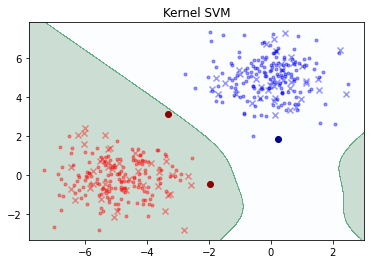

In [25]:
model3 = KernelSVM(nonlinear=4, zeta=1, gamma=1, gauss=False)
model3.quadratic_programming(x_train, y_train)

sv, sv_y = model3.sv, model3.sv_y
model3.eval(x_test, y_test)

# 画决策边界
plot_decision_boundary(x_train, model3, h=0.01)
plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='.', c='red')
plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='.', c='blue')
plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='red')
plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')

pos_idx = np.where(sv_y==1)[0]
pos_sv = sv[pos_idx]
neg_idx = np.where(sv_y==-1)[0]
neg_sv = sv[neg_idx]
plt.scatter(pos_sv[:,0], pos_sv[:,1], alpha=1, marker='o', c='darkred')
plt.scatter(neg_sv[:,0], neg_sv[:,1], alpha=1, marker='o', c='darkblue')

plt.title('Kernel SVM')
plt.show()

高斯核函数

     pcost       dcost       gap    pres   dres
 0: -7.6287e+00 -2.5997e+01  2e+01  3e-15  2e+00
 1: -8.0182e+00 -1.0718e+01  3e+00  2e-15  3e-01
 2: -8.2981e+00 -8.7496e+00  5e-01  4e-16  3e-02
 3: -8.3284e+00 -8.3881e+00  6e-02  4e-15  3e-03
 4: -8.3334e+00 -8.3421e+00  9e-03  6e-15  3e-04
 5: -8.3344e+00 -8.3355e+00  1e-03  2e-15  7e-06
 6: -8.3345e+00 -8.3347e+00  2e-04  4e-16  1e-06
 7: -8.3346e+00 -8.3346e+00  2e-05  3e-15  6e-08
 8: -8.3346e+00 -8.3346e+00  1e-06  2e-15  4e-09
Optimal solution found.
测试集准确率 1.00
(10, 2)


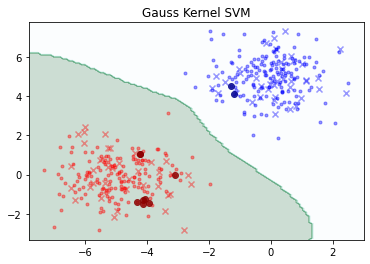

In [26]:
model4 = KernelSVM(nonlinear=4, zeta=1, gamma=1, gauss=True)
model4.quadratic_programming(x_train, y_train)

sv, sv_y = model4.sv, model4.sv_y
model4.eval(x_test, y_test)

plot_decision_boundary(x_train, model4, h=0.1)
plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='.', c='red')
plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='.', c='blue')
plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='red')
plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')

alpha = model4.alpha
idx = np.argsort(alpha, axis=0)[:10].squeeze()
sv = sv[idx]
sv_y = sv_y[idx]
print(sv.shape)
pos_idx = np.where(sv_y==1)[0]
pos_sv = sv[pos_idx]
neg_idx = np.where(sv_y==-1)[0]
neg_sv = sv[neg_idx]
plt.scatter(pos_sv[:,0], pos_sv[:,1], alpha=0.8, marker='o', c='darkred')
plt.scatter(neg_sv[:,0], neg_sv[:,1], alpha=0.8, marker='o', c='darkblue')

plt.title('Gauss Kernel SVM')
plt.show()

改变数据集的均值向量 **<font color="Red">（问题3）</font>**

Size of Dataset: 
x_train: (320, 2)
y_train: (320, 1)
x_test: (80, 2)
y_test: (80, 1)


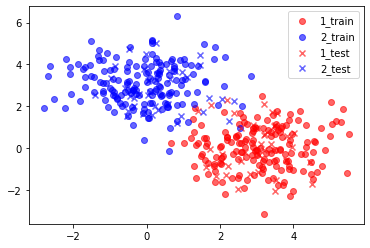

In [27]:
data2 = Dataset(means1=[3,0], means2=[0,3])
x_train, x_test = data2.x_train, data2.x_test
y_train, y_test = data2.y_train, data2.y_test
print('Size of Dataset: ')
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test: {}".format(y_test.shape))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.6, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.6, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.6, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.6, marker='x', c='blue')
plt.legend(handles=[c1, c2, c3, c4],labels=['1_train','2_train', '1_test', '2_test'],loc='best')
plt.show()

线性支持向量机

使用二次规划求解的线性支持向量机计算最大间隔面,显然由于数据不是线性可分的，线性支持向量机无法进行分类

In [28]:
modelt1 = SVM(dimension=2)
modelt1.quadratic_programming(x_train, y_train)

     pcost       dcost       gap    pres   dres
 0:  6.8529e-02  1.5770e+02  1e+03  2e+00  1e+03
 1:  2.7289e-01 -1.5920e+02  1e+03  2e+00  9e+02
 2:  2.2603e-01  1.8661e+02  1e+03  2e+00  9e+02
 3:  5.6895e-04  2.5700e+03  1e+03  1e+00  7e+02
 4:  5.0433e-04  6.5608e+03  1e+03  1e+00  6e+02
 5:  2.7084e-04  1.0251e+04  2e+03  1e+00  6e+02
 6:  1.9440e-04  3.2602e+04  4e+03  1e+00  6e+02
 7:  1.4428e-04  7.6325e+04  8e+03  1e+00  6e+02
 8:  1.3948e-04  8.4037e+04  8e+03  1e+00  6e+02
 9:  1.1974e-04  1.5569e+05  1e+04  1e+00  6e+02
10:  1.0633e-04  1.7251e+05  2e+04  1e+00  6e+02
11:  1.6805e-05  1.4430e+06  5e+04  1e+00  5e+02
12:  8.9258e-06  1.3229e+07  3e+05  1e+00  5e+02
13:  4.8589e-06  1.5497e+08  3e+06  1e+00  5e+02
14:  4.1823e-07  6.1810e+09  3e+07  1e+00  5e+02
15:  7.6937e-10  1.1020e+12  3e+08  1e+00  5e+02
16:  9.9518e-14  4.6828e+15  1e+10  1e+00  5e+02
17:  1.2098e-17  1.7495e+21  5e+13  1e+00  6e+05
18:  6.1694e-18  1.7142e+28  4e+20  1e+00  4e+12
19:  1.6990e-19  6.88

核函数支持向量机

核函数的引进使得SVM具有非线性分类的能力，首先使用四次核函数

     pcost       dcost       gap    pres   dres
 0: -2.9850e+01 -7.9579e+01  1e+03  2e+01  3e+00
 1: -6.9347e+01 -1.4125e+02  9e+02  2e+01  2e+00
 2: -2.3536e+02 -4.3659e+02  9e+02  1e+01  2e+00
 3: -5.3017e+02 -7.6263e+02  8e+02  1e+01  1e+00
 4: -9.5835e+02 -1.2363e+03  9e+02  1e+01  1e+00
 5: -2.2783e+03 -2.6516e+03  1e+03  9e+00  1e+00
 6: -4.7389e+03 -5.2794e+03  1e+03  9e+00  1e+00
 7: -8.0096e+03 -8.7522e+03  2e+03  9e+00  1e+00
 8: -1.4418e+04 -1.5359e+04  3e+03  9e+00  1e+00
 9: -1.4430e+04 -1.5032e+04  4e+03  8e+00  1e+00
10: -1.4301e+04 -1.4707e+04  5e+03  8e+00  1e+00
11: -1.3505e+04 -1.3249e+04  7e+03  8e+00  1e+00
12: -1.1939e+04 -1.0092e+04  9e+03  6e+00  8e-01
13: -6.4545e+03 -4.4362e+03  9e+03  4e+00  4e-01
14: -5.5651e+03 -3.7267e+03  8e+03  3e+00  4e-01
15: -3.2699e+03 -2.7676e+03  7e+03  2e+00  3e-01
16: -1.6158e+03 -2.1848e+03  6e+03  1e+00  1e-01
17: -1.3537e+03 -1.6399e+03  2e+03  3e-01  4e-02
18: -1.3005e+03 -1.4879e+03  2e+02  1e-02  2e-03
19: -1.3663e+03 -1.46

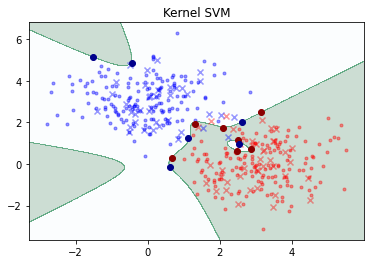

In [29]:
modelt2 = KernelSVM(nonlinear=4, zeta=1, gamma=1, gauss=False)
modelt2.quadratic_programming(x_train, y_train)

sv, sv_y = modelt2.sv, modelt2.sv_y
modelt2.eval(x_test, y_test)

# 画决策边界
plot_decision_boundary(x_train, modelt2, h=0.01)
plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='.', c='red')
plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='.', c='blue')
plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='red')
plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')

pos_idx = np.where(sv_y==1)[0]
pos_sv = sv[pos_idx]
neg_idx = np.where(sv_y==-1)[0]
neg_sv = sv[neg_idx]
plt.scatter(pos_sv[:,0], pos_sv[:,1], alpha=1, marker='o', c='darkred')
plt.scatter(neg_sv[:,0], neg_sv[:,1], alpha=1, marker='o', c='darkblue')

plt.title('Kernel SVM')
plt.show()

再使用高斯核函数

     pcost       dcost       gap    pres   dres
 0: -1.8316e+01 -6.9973e+01  8e+02  2e+01  2e+00
 1: -1.3697e+01 -1.1522e+02  3e+02  4e+00  5e-01
 2: -2.2554e+01 -7.2865e+01  6e+01  3e-01  4e-02
 3: -3.4048e+01 -4.8370e+01  2e+01  6e-02  8e-03
 4: -3.7569e+01 -4.1183e+01  4e+00  1e-14  1e-15
 5: -3.8524e+01 -3.9125e+01  6e-01  4e-15  1e-15
 6: -3.8683e+01 -3.8831e+01  1e-01  2e-14  1e-15
 7: -3.8722e+01 -3.8743e+01  2e-02  2e-14  1e-15
 8: -3.8730e+01 -3.8733e+01  3e-03  2e-14  1e-15
 9: -3.8731e+01 -3.8731e+01  7e-04  2e-14  1e-15
10: -3.8731e+01 -3.8731e+01  8e-05  1e-14  1e-15
11: -3.8731e+01 -3.8731e+01  5e-06  3e-15  1e-15
Optimal solution found.
测试集准确率 0.94


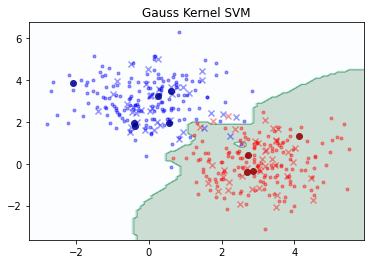

In [30]:
modelt3 = KernelSVM(nonlinear=4, zeta=1, gamma=1, gauss=True)
modelt3.quadratic_programming(x_train, y_train)

sv, sv_y = modelt3.sv, modelt3.sv_y
modelt3.eval(x_test, y_test)

plot_decision_boundary(x_train, modelt3, h=0.1)
plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='.', c='red')
plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='.', c='blue')
plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='red')
plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')

alpha = modelt3.alpha
idx = np.argsort(alpha, axis=0)[:10].squeeze()
sv = sv[idx]
sv_y = sv_y[idx]
pos_idx = np.where(sv_y==1)[0]
pos_sv = sv[pos_idx]
neg_idx = np.where(sv_y==-1)[0]
neg_sv = sv[neg_idx]
plt.scatter(pos_sv[:,0], pos_sv[:,1], alpha=0.8, marker='o', c='darkred')
plt.scatter(neg_sv[:,0], neg_sv[:,1], alpha=0.8, marker='o', c='darkblue')

plt.title('Gauss Kernel SVM')
plt.show()

**钓鱼岛问题** **<font color="Red">（问题5）</font>**
- 训练集:
中国与日本的沿海城市的经纬度坐标向量，中国标签为+1, 日本为标签为-1.
- 测试集: 
钓鱼岛的经纬度坐标向量
- 要求
用支撑向量机设计分类器，（1）判断钓鱼岛属于哪一类；（2）增加几个非海边城市的经纬度坐标进行训练，判断这些城市是否影响分类结果，是否为支撑向量。

构造数据集并进行可视化


x_train: (14, 2)  y_train: (14, 1)
xp_train: (20, 2)  yp_train: (20, 1)


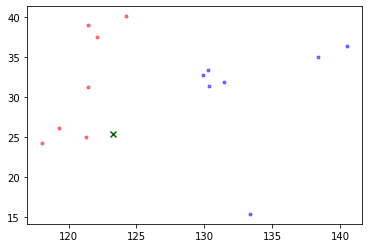

In [31]:
import data.location as loc

xn1 = np.array(loc.xn1).reshape(-1, 2)
xn2 = np.array(loc.xn2).reshape(-1, 2)
yn1 = np.ones((7,1))
yn2 = np.ones((7,1)) * -1

xn_train = np.concatenate((xn1,xn2),axis=0)
yn_train = np.concatenate((yn1,yn2),axis=0)

xa1 = np.array(loc.xa1).reshape(-1, 2)
xa2 = np.array(loc.xa2).reshape(-1, 2)
ya1 = np.ones((10,1))
ya2 = np.ones((10,1)) * -1

xa_train = np.concatenate((xa1,xa2),axis=0)
ya_train = np.concatenate((ya1,ya2),axis=0)

print('x_train: {}  y_train: {}'.format(xn_train.shape, yn_train.shape))
print('xp_train: {}  yp_train: {}'.format(xa_train.shape, ya_train.shape))

c1 = plt.scatter(xn1[:,0], xn1[:,1], alpha=0.5, marker='.', c='red')
c2 = plt.scatter(xn2[:,0], xn2[:,1], alpha=0.5, marker='.', c='blue')
c3 = plt.scatter(loc.XC[0], loc.XC[1], alpha=1, marker='x', c='darkgreen')
plt.show()

使用对偶SVM分别分析两种情况，并可视化结果

只添加沿海城市

     pcost       dcost       gap    pres   dres
 0: -2.4282e+00 -4.1387e+00  4e+01  6e+00  2e+00
 1: -7.8678e-01 -4.4407e-01  1e+01  1e+00  4e-01
 2:  4.9327e-03 -1.1769e-01  2e-01  2e-02  4e-03
 3: -2.4933e-02 -5.4376e-02  3e-02  7e-18  1e-13
 4: -3.8454e-02 -4.2043e-02  4e-03  1e-17  8e-14
 5: -4.1578e-02 -4.1638e-02  6e-05  8e-18  8e-14
 6: -4.1624e-02 -4.1624e-02  6e-07  1e-17  1e-13
 7: -4.1624e-02 -4.1624e-02  6e-09  1e-17  8e-14
Optimal solution found.
w: [[-0.28323918]
 [ 0.05499058]]
b: [33.98333015]


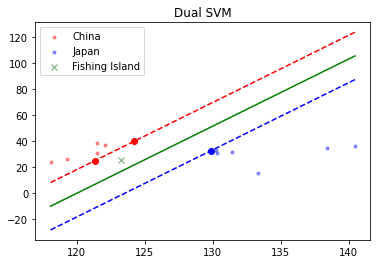

In [32]:
modelx1 = DualSVM(dimension=2)
modelx1.quadratic_programming(xn_train, yn_train)

sv, sv_y = modelx1.support_vector, modelx1.support_vector_y
w, b = modelx1.w, modelx1.b
print('w: {}'.format(w))
print('b: {}'.format(b))

c1 = plt.scatter(xn1[:,0], xn1[:,1], alpha=0.4, marker='.', c='red')
c2 = plt.scatter(xn2[:,0], xn2[:,1], alpha=0.4, marker='.', c='blue')
c3 = plt.scatter(loc.XC[0], loc.XC[1], alpha=0.4, marker='x', c='darkgreen')

pos_idx = np.where(sv_y==1)[0]
pos_sv = sv[pos_idx]
neg_idx = np.where(sv_y==-1)[0]
neg_sv = sv[neg_idx]

c4 = plt.scatter(pos_sv[:,0], pos_sv[:,1], alpha=1, marker='o', c='red')
c5 = plt.scatter(neg_sv[:,0], neg_sv[:,1], alpha=1, marker='o', c='blue')

xmax, xmin = np.max(xn_train[:,0]), np.min(xn_train[:,0])
x = np.linspace(xmin, xmax, num=100)
y = -(w[0] * x + b) / w[1]
plt.plot(x, y,c='green')

pos_b = - w[0] * pos_sv[0][0] - w[1] * pos_sv[0][1]
pos_f = -(w[0] * x+pos_b) / w[1]
neg_b = - w[0] * neg_sv[0][0] - w[1] * neg_sv[0][1]
neg_f = -(w[0] * x+neg_b) / w[1]

plt.plot(x, pos_f, '--', c='red')
plt.plot(x, neg_f, '--', c='blue')
plt.legend(handles=[c1, c2, c3],labels=['China','Japan','Fishing Island'],loc='best')
plt.title('Dual SVM')
plt.show()

可视化结果

添加内陆城市后

     pcost       dcost       gap    pres   dres
 0: -4.9743e+00 -8.4377e+00  6e+01  9e+00  2e+00
 1: -4.8968e+00 -2.3887e+00  2e+01  3e+00  5e-01
 2: -1.8059e-01 -8.7088e-02  1e+00  1e-01  2e-02
 3: -1.2370e-02 -7.1962e-02  6e-02  2e-17  3e-13
 4: -3.4933e-02 -4.2696e-02  8e-03  8e-18  7e-14
 5: -4.1277e-02 -4.1747e-02  5e-04  7e-18  7e-14
 6: -4.1621e-02 -4.1625e-02  5e-06  8e-18  1e-13
 7: -4.1624e-02 -4.1624e-02  5e-08  8e-18  2e-13
Optimal solution found.
w: [[-0.28323921]
 [ 0.05499059]]
b: [33.98333457]


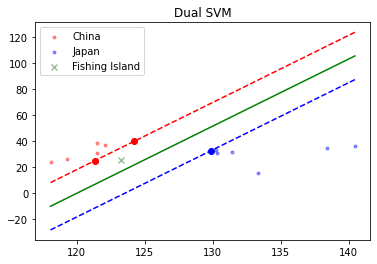

In [33]:
modelx2 = DualSVM(dimension=2)
modelx2.quadratic_programming(xa_train, ya_train)

sv, sv_y = modelx2.support_vector, modelx2.support_vector_y
b, w = modelx2.b, modelx2.w
print('w: {}'.format(w))
print('b: {}'.format(b))

c1 = plt.scatter(xn1[:,0], xn1[:,1], alpha=0.4, marker='.', c='red')
c2 = plt.scatter(xn2[:,0], xn2[:,1], alpha=0.4, marker='.', c='blue')
c3 = plt.scatter(loc.XC[0], loc.XC[1], alpha=0.4, marker='x', c='darkgreen')

pos_idx = np.where(sv_y==1)[0]
pos_sv = sv[pos_idx]
neg_idx = np.where(sv_y==-1)[0]
neg_sv = sv[neg_idx]

c4 = plt.scatter(pos_sv[:,0], pos_sv[:,1], alpha=1, marker='o', c='red')
c5 = plt.scatter(neg_sv[:,0], neg_sv[:,1], alpha=1, marker='o', c='blue')

xmax, xmin = np.max(xn_train[:,0]), np.min(xn_train[:,0])
x = np.linspace(xmin, xmax, num=100)
y = -(w[0] * x + b) / w[1]
plt.plot(x, y,c='green')

pos_b = - w[0] * pos_sv[0][0] - w[1] * pos_sv[0][1]
pos_f = -(w[0] * x+pos_b) / w[1]
neg_b = - w[0] * neg_sv[0][0] - w[1] * neg_sv[0][1]
neg_f = -(w[0] * x+neg_b) / w[1]

plt.plot(x, pos_f, '--', c='red')
plt.plot(x, neg_f, '--', c='blue')
plt.legend(handles=[c1, c2, c3],labels=['China','Japan','Fishing Island'],loc='best')
plt.title('Dual SVM')
plt.show()

由可以看出，内陆城市不影响决策面。因此，不管哪种情况，SVM划分的结果钓鱼岛都是属于中国的。

从原理角度上说SVM的决策面仅仅是有支撑向量决定，与非支撑向量无关，所以两种情况下决策面是相同的